# 1_data_visualisation.ipynb

This notebook visualises the Maltese Traffic Signs Dataset (MTSD) exported in COCO format.

**Expected inputs (edit paths in the next cell if needed):**
- `COCO.json` (full dataset, sign-type categories)
- `COCO_sign_shape.json` (same images/boxes, but categories are sign-shape)
- `images/` (single unified images directory)

It produces:
- Dataset size + class balance tables
- Attribute distributions (viewing angle, mounting type, condition, sign shape)
- Example visualisations with bounding boxes + attribute overlay

> Note: To run the notebook, dataset paths needs to be changed since the repo structure had to be modified to align with submission requirements.


In [ ]:
# Paths
from pathlib import Path

# Root directory (notebook location)
ROOT_DIR = Path(".").resolve()

# Outputs directory
OUTPUTS_DIR = ROOT_DIR / "Outputs"

# Dataset paths
IMAGES_DIR = OUTPUTS_DIR / "images"
COCO_PATH = OUTPUTS_DIR / "COCO.json"
COCO_SHAPE_PATH = OUTPUTS_DIR / "COCO_sign_shape.json"

# Safety checks (highly recommended)
assert OUTPUTS_DIR.exists(), f"{OUTPUTS_DIR} not found"
assert IMAGES_DIR.exists(), f"{IMAGES_DIR} not found"

In [6]:
import json
import pandas as pd

def load_coco(path):
    with open(path, 'r', encoding='utf-8') as f:
        return json.load(f)

coco_all = load_coco(COCO_PATH)
coco_shape = load_coco(COCO_SHAPE_PATH)

print('COCO.json:', len(coco_all['images']), 'images,', len(coco_all['annotations']), 'annotations,', len(coco_all['categories']), 'categories')
print('COCO_sign_shape.json:', len(coco_shape['images']), 'images,', len(coco_shape['annotations']), 'annotations,', len(coco_shape['categories']), 'categories')


COCO.json: 620 images, 654 annotations, 11 categories
COCO_sign_shape.json: 620 images, 654 annotations, 5 categories


In [ ]:
# Basic distributions: sign type & sign shape
from collections import Counter

def cat_maps(coco):
    id_to_name = {c['id']: c['name'] for c in coco['categories']}
    return id_to_name

id2name_all = cat_maps(coco_all)
id2name_shape = cat_maps(coco_shape)

type_counts = Counter(id2name_all[a['category_id']] for a in coco_all['annotations'])
shape_counts = Counter(id2name_shape[a['category_id']] for a in coco_shape['annotations'])

df_type = pd.DataFrame(type_counts.items(), columns=['sign_type', 'count']).sort_values('count', ascending=False)
df_shape = pd.DataFrame(shape_counts.items(), columns=['sign_shape', 'count']).sort_values('count', ascending=False)

display(df_type)
display(df_shape)


,sign_type,count
0,Stop,151
2,No Entry (One Way),145
5,Pedestrian Crossing,89
7,No_Entry,68
4,Roundabout Ahead,61
1,Blind-Spot Mirror (Convex),45
3,No Through Road (T-Sign),37
9,Pedestrian_Crossing,36
6,No Through Road,12
8,No_Through_Road,6


,sign_shape,count
1,Circular,289
0,Octagonal,143
2,Square,138
3,Triangular,78
4,Damaged,6


In [ ]:
# Attribute distributions 

# Label Studio exports sometimes vary attribute keys so we normalise to canonical names
CANON = {
    'viewing_angle': ['viewing_angle', 'view_angle', 'attr_angle', 'attr_angle', 'angle'],
    'mounting_type': ['mounting_type', 'mounting', 'attr_mounting'],
    'sign_condition': ['sign_condition', 'condition', 'attr_condition'],
    'sign_shape': ['sign_shape', 'attr_shape', 'shape'],
}

def pick_attr(attr_dict, canon_key):
    if not isinstance(attr_dict, dict):
        return None
    for k in CANON[canon_key]:
        if k in attr_dict:
            v = attr_dict[k]
            # Label Studio often stores as list like ['Front']
            if isinstance(v, list) and v:
                return v[0]
            return v
    return None

from collections import defaultdict

dist = {k: defaultdict(int) for k in CANON.keys()}

for ann in coco_all['annotations']:
    ad = ann.get('attributes', {})
    for ck in CANON.keys():
        v = pick_attr(ad, ck)
        if v is not None:
            dist[ck][str(v)] += 1

for k in dist:
    df = pd.DataFrame(sorted(dist[k].items(), key=lambda x: -x[1]), columns=[k, 'count'])
    print('', k)
    display(df)

 viewing_angle


,viewing_angle,count
0,[],171
1,Back,166
2,Front,159
3,Side,158


 mounting_type


,mounting_type,count
0,Pole-mounted,456
1,[],171
2,Wall-mounted,27


 sign_condition


,sign_condition,count
0,Good,390
1,[],171
2,Weathered,80
3,Heavily_Damaged,7
4,Heavily Damaged,6


 sign_shape


,sign_shape,count
0,Circular,232
1,[],171
2,Square,111
3,Octagonal,110
4,Triangular,30


[SKIP] Could not open image: C:\Users\matth\OneDrive\Documents\UM\Advanced Computer Vision for AI\Group Project\Outputs\images\160887fc-IMG_0198.jpg (UnidentifiedImageError: cannot identify image file 'C:\\Users\\matth\\OneDrive\\Documents\\UM\\Advanced Computer Vision for AI\\Group Project\\Outputs\\images\\160887fc-IMG_0198.jpg')


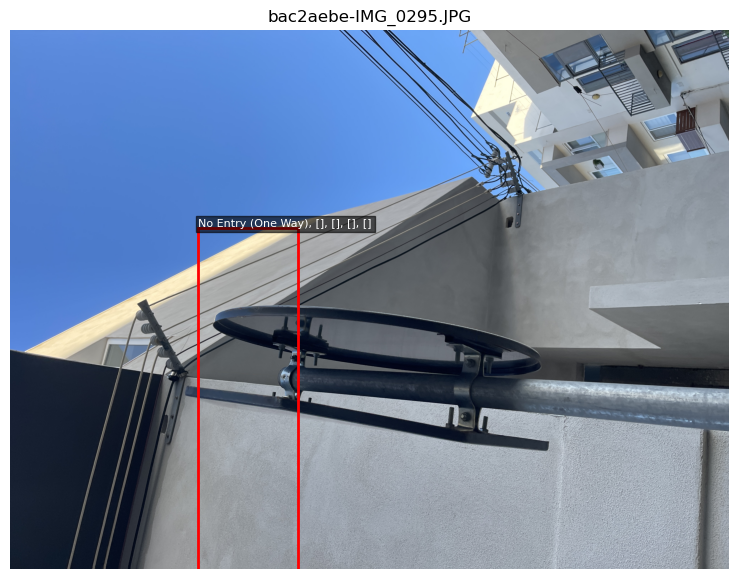

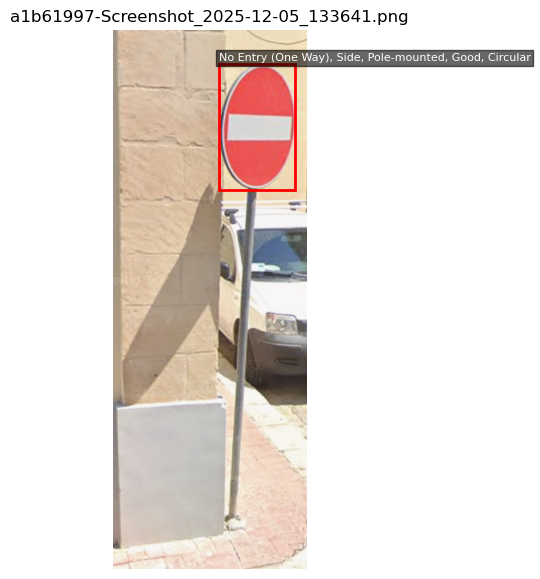

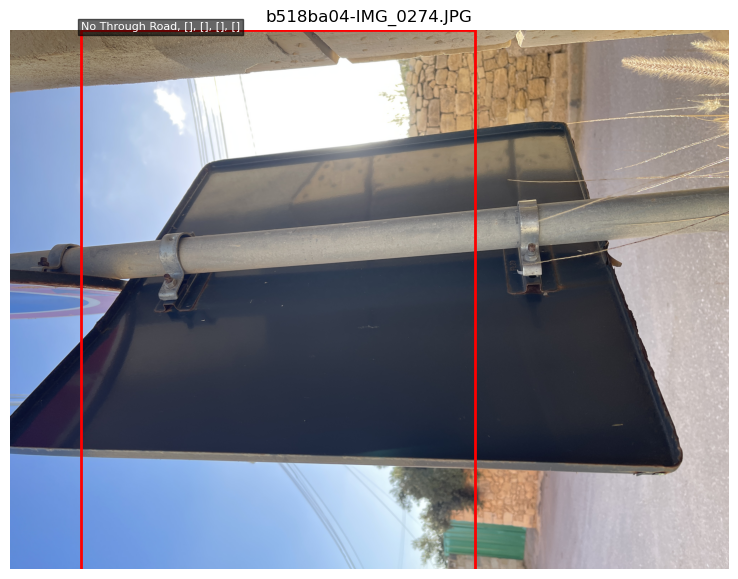

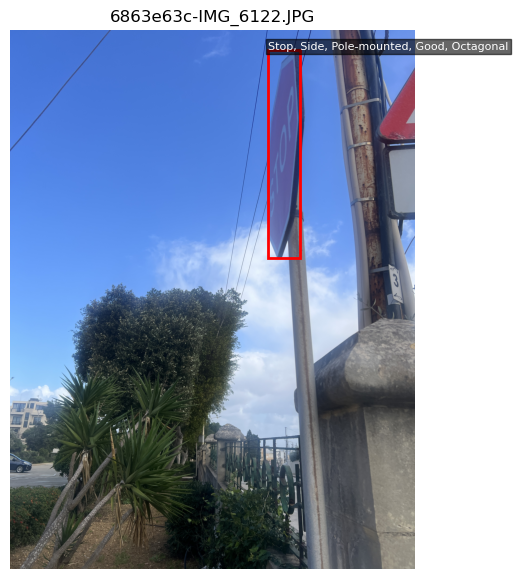

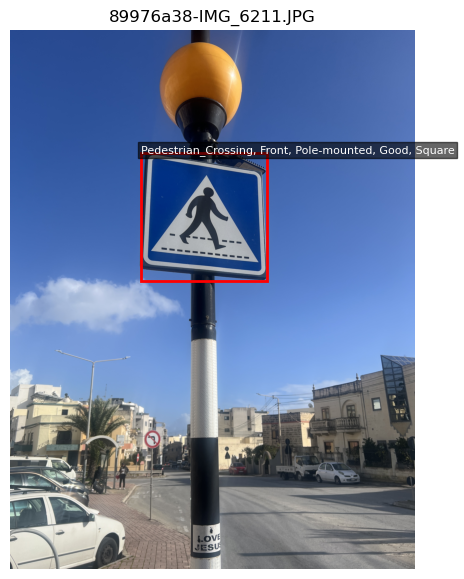

In [ ]:
# Visualise random examples with bounding boxes + attributes
import random
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
import matplotlib.patches as patches

img_by_id = {im['id']: im for im in coco_all['images']}
anns_by_img = {}
for ann in coco_all['annotations']:
    anns_by_img.setdefault(ann['image_id'], []).append(ann)

def draw_example(image_id):
    rec = img_by_id[image_id]
    path = IMAGES_DIR / rec['file_name']

    # Skip missing/unreadable images (keeps everything else the same)
    try:
        img = Image.open(path).convert('RGB')
    except (FileNotFoundError, UnidentifiedImageError, OSError) as e:
        print(f"[SKIP] Could not open image: {path} ({type(e).__name__}: {e})")
        return False  # signal failure

    fig, ax = plt.subplots(figsize=(10, 7))
    ax.imshow(img)
    ax.set_title(rec['file_name'])
    ax.axis('off')

    for ann in anns_by_img.get(image_id, []):
        x, y, w, h = ann['bbox']
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

        stype = id2name_all.get(ann['category_id'], str(ann['category_id']))
        ad = ann.get('attributes', {})
        angle = pick_attr(ad, 'viewing_angle')
        mount = pick_attr(ad, 'mounting_type')
        cond = pick_attr(ad, 'sign_condition')
        shape = pick_attr(ad, 'sign_shape')

        label = f"{stype}, {angle}, {mount}, {cond}, {shape}"
        ax.text(x, max(0, y-5), label, color='white', fontsize=8,
                bbox=dict(facecolor='black', alpha=0.6, pad=2))

    plt.show()
    return True  # signal success

# Try to draw 5 valid examples, skipping bad ones
target_examples = 5
max_attempts = 50  # prevents infinite loop if many images are bad
keys = list(img_by_id.keys())

shown = 0
attempts = 0
while shown < target_examples and attempts < max_attempts:
    attempts += 1
    ok = draw_example(random.choice(keys))
    if ok:
        shown += 1

if shown < target_examples:
    print(f"Only displayed {shown}/{target_examples} examples (hit max_attempts={max_attempts}).")